In [46]:
import sys
import numpy as np
sys.path.append("/Users/hakunahahannah/Documents/Projects/Spiking/Analysis/SpikeAnalysisToolbox/")

import spikeAnalysisToolsV2.data_loading as data
import spikeAnalysisToolsV2.synapse_analysis as synapse_analysis
import spikeAnalysisToolsV2.plotting as spikeplot
import spikeAnalysisToolsV2.helper as helper
import spikeAnalysisToolsV2.firing_rates as firing
import spikeAnalysisToolsV2.information_scores as info

from IPython.display import HTML
from matplotlib import rc
rc('animation', html='html5')

In [47]:
masterpath = "/Users/hakunahahannah/Documents/Projects/Spiking/Build/output"
experiment = "/20Ex20Id_fanIn_230_epochs/"
basic_path = masterpath+experiment

network_architecture = dict(num_inh_neurons_per_layer = 32*32, num_exc_neurons_per_layer= 64*64, num_layers=4)
epochs = list(range(1, 401))
#type(epochs[0])
print(type(epochs[0]))

<class 'int'>


In [48]:
if type(epochs[0]) ==int:
    print("Epochs given as indices")
    all_epoch_paths = [basic_path+"testing"+"/epoch{}".format(e) for e in epochs]
if type(epochs[0]) == str:
        print("Epochs given by subfolder names")
        all_epoch_paths = [basic_path + "/" + epoch_name for epoch_name in epochs]

Epochs given as indices


In [53]:
full_network_initial = data.load_network(basic_path + "initial")
#in my network the weights are not listed for tested epochs 
#weights_all_epochs = list(map(data.load_only_weights, all_epoch_paths))
#weight_matrix = np.stack([full_network_initial.weights.values] + weights_all_epochs, axis=0)
print(full_network_initial)

          delays   post    pre   weights
0              1      0  -3850  0.000329
1              1      0   -782  0.524587
2              1      0  -2049  0.735424
3              1      0  -7698  0.263306
4              1      0  -1289  0.376224
5              1      0   -517  0.196286
6              1      0  -6915  0.975874
7              1      0  -6162  0.512318
8              1      0  -7945  0.530449
9              1      0   -522  0.257102
10             1      0  -1545  0.107087
11             1      0   -525  0.815488
12             1      0  -2821  0.900545
13             1      0  -6670  0.452029
14             1      0  -7706  0.245389
15             1      0  -2310  0.247408
16             1      0  -1042  0.188274
17             1      0  -1042  0.323324
18             1      0  -8722  0.103457
19             1      0  -7711  0.807374
20             1      0  -3073  0.534411
21             1      0  -5121  0.844454
22             1      0   -279  0.737019
23             1

In [37]:
#won't stop raising an incorrect error
#net, weights = data.load_weights_all_epochs(masterpath+experiment, epochs)

In [52]:

    
#this won't work due to the wildcards. needs further investigation. Look at synapses_networkPost??


object_list = data.load_testing_stimuli_info(folder + experiment)
n_stimuli = np.sum([obj['count'] for obj in object_list])
print(n_stimuli)
object_list_shape = data.load_testing_stimuli_indices_from_wildcarts(folder+"/" + experiment, ["***r", "***l"])
object_indices_shape = [o['indices'] for o in object_list_shape]
object_indices = object_list_shape

info_times = dict(
    length_of_stimulus = 2.0,
    num_stimuli = n_stimuli,
    time_start = 1.5,
    time_end = 1.9
)

spikes = data.load_spikes_from_subfolders(folder, [experiment], ["initial"]+["/testing/epoch{}".format(e) for e in epochs], False)
print("loading done")


rates_subfolders = firing.calculate_rates_subfolder(
    spikes,
    network_architecture, 
    info_times)



exc_mutual_info , _inh_mutual_info = info.information_all_epochs(rates_subfolders[0],'mutual_info', objects=object_indices, n_bins=3)

print(exc_mutual_info.shape)

mean_of_top_n = 1000
top_2_exc = np.sort(exc_mutual_info, axis=3)[:, :, :, -1-mean_of_top_n:]

top_n_mean_perf = np.mean(top_2_exc, axis=3)[:, 0, :] # secod dimension is 1. (~ information about 1 object which is actually the mean information of both)


NameError: name 'folder' is not defined

In [ ]:
top_n_mean_perf.shape

In [ ]:
mask = synapse_analysis.Synapse_Mask(network_architecture, net)
e2e_mask = mask.exc_feed_forward()

development_of_sample_synapses = synapse_analysis.get_weight_development_random_sample(weights[:, e2e_mask], 50*50)
development_of_sample_synapses -= development_of_sample_synapses[0, :]


In [ ]:
threshold=0.9
n_neurons_above = np.zeros((len(epochs)+1,1))
n_neurons_above = np.count_nonzero(exc_mutual_info >= threshold, axis=3)[:, 0, :]
print(n_neurons_above.shape)

In [ ]:
# or top_n_mean_perf
ani = spikeplot.animate_2d_matrix(development_of_sample_synapses, n_neurons_above, "Weight development for e2e synapses", label_perf=None, cmap="bwr")
HTML(ani.to_html5_video())


# Incoming Synapses to single Neuron

In [ ]:
def weight_vs_info_for_neuron(neuron_pos):
    info_that_neuron = exc_mutual_info[:, 0, neuron_pos[0], neuron_pos[1]]
    

    overall_id = helper.position_to_id(neuron_pos, True, network_architecture)
    pos_2d = helper.id_to_position(overall_id, network_architecture)

    mask_incoming_e_to_that_neuron = np.logical_and( net.post.values == overall_id , np.invert(mask.inh_lateral()))

    n_syn = np.count_nonzero(mask_incoming_e_to_that_neuron)
    needed_padding = int(np.ceil(np.sqrt(n_syn))**2 - n_syn)

    incoming_synapses = weights[:, mask_incoming_e_to_that_neuron]
    
    padded_incoming_synapses_weight_dev = np.pad(incoming_synapses, ((0,0), (0, needed_padding)), mode='constant')
    padded_incoming_synapses_weight_dev -= padded_incoming_synapses_weight_dev[0, :]
    
    #weight_stuff
    mean_weight = np.mean(incoming_synapses, axis=1)
    # number of changed synapses
    max_diff = np.max(padded_incoming_synapses_weight_dev)
    epsilon = 0.05
    n_changed = np.count_nonzero(padded_incoming_synapses_weight_dev > epsilon*max_diff, axis=1)
    max_n_changed = np.max(n_changed)
    n_changed = n_changed / max_n_changed

    
    all_information_measures = np.concatenate([np.expand_dims(bla, 1) for bla in [info_that_neuron, mean_weight, n_changed]], axis=1)

    
    

    ani = spikeplot.animate_2d_matrix(padded_incoming_synapses_weight_dev, all_information_measures, "incoming synapses to neuron: {}".format(pos_2d), 
                                      label_perf=["information", "avg weight", "n changed synapses (/{})".format(max_n_changed)], cmap="bwr")
    return  HTML(ani.to_html5_video())

In [ ]:
layer = 2

decreasing_indices = np.argsort(exc_mutual_info, axis=3)[:,:, :, ::-1]
target_n = decreasing_indices[82, 0, layer, 0]

# maybe plot a histogram of absolute weights in here as well

# Nice Neuron: L 2, N 1428
neuron_pos = (2, target_n)

weight_vs_info_for_neuron(neuron_pos)

In [ ]:
target_n = decreasing_indices[82, 0, layer, 1]
# Nice Neuron: L 2, N 1428
neuron_pos = (2, target_n)

weight_vs_info_for_neuron(neuron_pos)

In [ ]:
target_n = decreasing_indices[82, 0, layer, -203]
# Nice Neuron: L 2, N 1428
neuron_pos = (2, target_n)

weight_vs_info_for_neuron(neuron_pos)

In [ ]:
target_n = decreasing_indices[82, 0, layer, -225]
# Nice Neuron: L 2, N 1428
neuron_pos = (2, target_n)

weight_vs_info_for_neuron(neuron_pos)

# Overall Weight Development

In [17]:
inhibitory_mask = np.invert(mask.inh_lateral() | mask.exc_to_inhibitory())
mean_weights = np.mean(weights[:, inhibitory_mask], axis=1)

In [8]:
mean_weights.shape

NameError: name 'mean_weights' is not defined

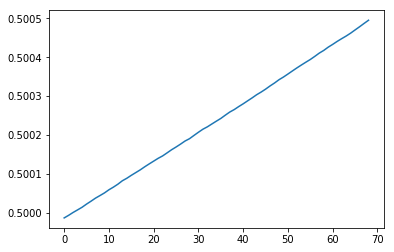

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(mean_weights)
